In [1]:
!pip install torch torchvision torchaudio scikit-learn medmnist

You should consider upgrading via the '/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/bin/python3 -m pip install --upgrade pip' command.


In [2]:
"""
Created on Mon Aug4 17:35:36 2025

@author: vigo
"""

import os
import sys
import argparse
import time
import pickle
from tqdm import trange
import numpy as np
import PIL
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50
import matplotlib.pyplot as plt
from scipy.io import savemat

#Related medmnist dataset
import medmnist
from medmnist import INFO, Evaluator


if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU instead.")
    
# Check for Cuda 
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


seed = 27
torch.manual_seed(seed)
random.seed(seed)

# Hyper-parameters 
n_epochs = 10
batch_size = 128
lr = 0.0005

#Network Hyper-parameters
hidden_size = 512

data_flag = 'organamnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])



#To work with 28x28 size images
#data_transform = transforms.Compose([
                 #transforms.ToTensor(),
                 #transforms.Normalize(mean=[.5], std=[.5])])

### To work with 224x224 resolution images
data_transform = transforms.Compose(
            [transforms.Resize((224, 224), interpolation=PIL.Image.NEAREST), 
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])]) 

# Image Size 28x28. Set RGB =True if the dataset contains colour images
train_dataset = DataClass(split='train', transform=data_transform, download=True, as_rgb=False)
val_dataset = DataClass(split='val', transform=data_transform, download=True, as_rgb=False)
test_dataset = DataClass(split='test', transform=data_transform, download=True, as_rgb=False)


# Loaders that give 64 example batches
train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True)


val_loader = data.DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                shuffle=False)

test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False)

image, label = train_dataset[0]  # Get one sample image
print(f"Image shape: {image.shape}")


Using MPS device.
Image shape: torch.Size([1, 224, 224])


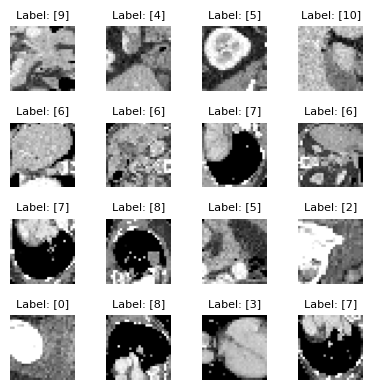

In [3]:
# select 16 random indices for plotting
indices = random.sample(range(len(train_dataset)), 16)

plt.figure(figsize=(4, 4))

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]

    # If tensor, convert to 2D array (grayscale)
    if hasattr(image, 'squeeze'):
        image = image.squeeze()  # remove channel dimension if present

    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
class AlexNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=96, kernel_size=11, stride=4, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(5 * 5* 256, 4096)
        self.d1= nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(4096, 1024)
        self.d2 =nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool1(F.relu(self.conv1(x)))   
        x = self.pool2(F.relu(self.conv2(x)))   
        x = F.relu(self.conv3(x))               
        x = F.relu(self.conv4(x))               
        x = self.pool3(F.relu(self.conv5(x)))   
        x = x.view(-1, 5 * 5 * 256)             
        x = self.d1(F.relu(self.fc1(x)))        
        #x = F.relu(self.bn1(self.fc1(x)))      
        x = self.d2(F.relu(self.fc2(x)))        
        x = self.fc3(x)                         
        #return torch.log_softmax(x, dim=1)      #for negative LL loss
        return x

conv_model = AlexNet(in_channels=n_channels, num_classes=n_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()   #One can tray NLL loss
optimizer = torch.optim.Adam(conv_model.parameters(), lr=lr, betas=(0.9, 0.999))  #One can try AdamW optimizer


In [5]:
# Training 
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    train_correct = 0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), torch.squeeze(targets, 1).long().to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(outputs, 1)
        train_correct += (predictions == targets).sum().item()
        total_samples += targets.size(0)

    train_acc = (train_correct / total_samples) * 100
    return train_acc, loss.item()


# Validation/Test
def val(model, dataloader, criterion, device):
    model.eval()
    val_correct = 0
    total_samples = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), torch.squeeze(targets, 1).long().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            _, predictions = torch.max(outputs, 1)

            val_correct += (predictions == targets).sum().item()
            total_samples += targets.size(0)
            val_loss += loss.item()

    val_acc = (val_correct / total_samples) * 100
    avg_val_loss = val_loss / len(dataloader)
    return val_acc, avg_val_loss

Epoch--[1], Train_Accuracy: 63.108706345302515, Validation_Accuracy: 93.31381913418579
Epoch--[2], Train_Accuracy: 91.16345013165127, Validation_Accuracy: 95.7787706054537
Epoch--[3], Train_Accuracy: 94.8815138450855, Validation_Accuracy: 97.07287012786936
Epoch--[4], Train_Accuracy: 97.13260611672116, Validation_Accuracy: 96.57987983361578
Epoch--[5], Train_Accuracy: 97.84728451144353, Validation_Accuracy: 96.94962255430596
Epoch--[6], Train_Accuracy: 98.50120077544052, Validation_Accuracy: 97.50423663534124
Epoch--[7], Train_Accuracy: 99.03648621278319, Validation_Accuracy: 97.21152364812818
Epoch--[8], Train_Accuracy: 98.97861751685426, Validation_Accuracy: 97.93560314281312
Epoch--[9], Train_Accuracy: 99.07120743034056, Validation_Accuracy: 96.98043444769681
Epoch--[10], Train_Accuracy: 99.16379734382686, Validation_Accuracy: 96.71853335387459


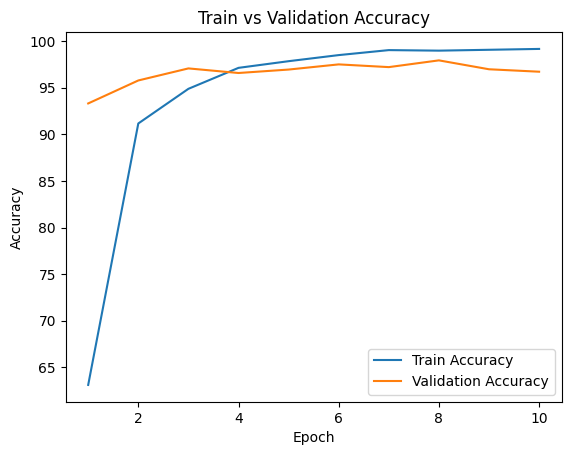

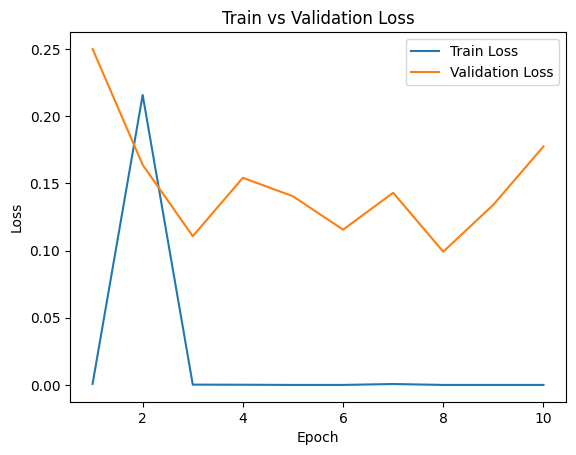

Test_Accuracy: 87.55203059961751


In [6]:
Train_Acc =[]
Train_Loss =[]

Val_Acc =[]
Val_Loss =[]

for epoch in range(n_epochs):
    train_acc, train_loss = train(conv_model, train_loader, criterion, optimizer, device)
    val_acc, val_loss = val(conv_model, val_loader, criterion, device)
    print (f'Epoch--[{epoch+1}], Train_Accuracy: {train_acc}, Validation_Accuracy: {val_acc}')
    Train_Acc.append(train_acc)
    Train_Loss.append(train_loss)
    Val_Acc.append(val_acc)
    Val_Loss.append(val_loss)




# Plot Epoch vs Accuracy
plt.figure()
plt.plot(range(1, n_epochs+1), Train_Acc, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), Val_Acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
#plt.grid(True)
plt.show()

# Plot Epoch vs Loss
plt.figure()
plt.plot(range(1, n_epochs+1), Train_Loss, label='Train Loss')
plt.plot(range(1, n_epochs+1), Val_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
#plt.grid(True)
plt.show()

#Testing
test_acc, test_loss = val(conv_model, test_loader, criterion, device)
print (f'Test_Accuracy: {test_acc}')